In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import datetime

In [4]:
#Shape files:
WASHINGTON_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'external', 'washington_blockgroup_shape', 'tl_2015_53_bg', 'tl_2015_53_bg.shp'))
TEXAS_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..','data','external','texas_blockgroup_shape','tl_2016_48_bg','tl_2016_48_bg.shp'))
GEORGIA_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..','data','external', 'georgia_blockgroup_shape','tl_2017_13_bg.shp'))
CALIFORNIA_SHAPE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..','data','external', 'california_blockgroup_shape','tl_2016_06_bg.shp'))

#Figures:
WASHINGTON_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'WA'))
TEXAS_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'TX'))
GEORGIA_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'GA'))
CALIFORNIA_FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures', 'CA'))
FIGURE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'reports', 'figures'))

#Data:
DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
WASHINGTON_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-washington.csv'))
GEORGIA_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-georgia.csv'))
TEXAS_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-texas.csv'))
CALIFORNIA_RAW_DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'stayathome-california.csv'))

#Income-population path:
INCOME_POPULATION_PATH = os.path.join(DATA_PATH, 'external', 'income_population')

In [5]:
#Load the data
def load_data(RAW_DATA_PATH):
    covid = pd.read_csv(RAW_DATA_PATH)
    covid_ = covid.set_index('Unnamed: 0')
    covid_ = covid_[covid_.columns[:117]] #to consider the same time period with our WA analysis
    #Prepare the data: drop nans
    X = covid_.dropna().values
    index_X = covid_.dropna().index
    columns_X = covid_.dropna().columns
    print('Data loaded:', X.shape, covid_.shape)
    return covid_.dropna(), X, index_X, columns_X

def response_slope(order_date, cbg_ts, before, after):
    """What is the amount of time it takes for a cbg to increase its stay-at-home by 20% (20% more ppl)"""
    """The slope during the first delay (week by default) after order cbg_ts should be a series indexed by date"""
    #First, identify the relevant time period
    cbg_ts.index = pd.to_datetime(cbg_ts.index)
    response_period = (cbg_ts.index > (order_date - datetime.timedelta(days=before))) & (cbg_ts.index <= (order_date + datetime.timedelta(days=after)))
#     print(response_period)
    response = cbg_ts[response_period]
    lr = LinearRegression()
    resp_ind = response.index.to_julian_date()
    resp_ind = np.array(resp_ind).reshape((-1,1))
#     print(np.array(response.index).reshape((-1,1)).shape)
    lr.fit(resp_ind, response)
#     plt.plot(response.index, response)
#     plt.plot(response.index, lr.predict(resp_ind))
#     print(lr.intercept_)
#     print(lr.coef_)
    slope = lr.coef_[0]
    return slope

def state_response_slopes(order_date, covid_wa, before, after):
    slopes_wa = []
    for block_ind in covid_wa.index:
        cbg_ts = covid_wa.loc[block_ind]
        slope = response_slope(order_date, cbg_ts, before = before, after = after)
        slopes_wa.append(slope)
    #     print(slope)
    slopes_wa = pd.Series(slopes_wa, index = covid_wa.index)
    return slopes_wa

In [65]:
#Load income-population data
inc_pop_wa = pd.read_csv(os.path.join(INCOME_POPULATION_PATH, 'acs2018-washington.csv'), index_col = 0)
washington = gpd.read_file(WASHINGTON_SHAPE_PATH).set_index('GEOID')
washington.index = washington.index.astype('int')
inc_pop_wa['pop2018'] = inc_pop_wa['pop2018'].drop(inc_pop_wa['pop2018'][inc_pop_wa['pop2018'] < 10].index)
inc_pop_wa['pop2018_density'] = np.log(inc_pop_wa['pop2018']/washington['ALAND'])

inc_pop_ga = pd.read_csv(os.path.join(INCOME_POPULATION_PATH, 'acs2018-georgia.csv'), index_col = 0)
georgia = gpd.read_file(GEORGIA_SHAPE_PATH).set_index('GEOID')
georgia.index = georgia.index.astype('int')
inc_pop_ga['pop2018'] = inc_pop_ga['pop2018'].drop(inc_pop_ga['pop2018'][inc_pop_ga['pop2018'] < 10].index)
inc_pop_ga['pop2018_density'] = np.log(inc_pop_ga['pop2018']/georgia['ALAND'])

inc_pop_tx = pd.read_csv(os.path.join(INCOME_POPULATION_PATH, 'acs2018-texas.csv'), index_col = 0)
texas = gpd.read_file(TEXAS_SHAPE_PATH).set_index('GEOID')
texas.index = texas.index.astype('int')
inc_pop_tx['pop2018'] = inc_pop_tx['pop2018'].drop(inc_pop_tx['pop2018'][inc_pop_tx['pop2018'] < 10].index)
inc_pop_tx['pop2018_density'] = np.log(inc_pop_tx['pop2018']/texas['ALAND'])

inc_pop_ca = pd.read_csv(os.path.join(INCOME_POPULATION_PATH, 'acs2018-california.csv'), index_col = 0)
california = gpd.read_file(CALIFORNIA_SHAPE_PATH).set_index('GEOID')
california.index = california.index.astype('int')
inc_pop_ca['pop2018'] = inc_pop_ca['pop2018'].drop(inc_pop_ca['pop2018'][inc_pop_ca['pop2018'] < 10].index)
inc_pop_ca['pop2018_density'] = np.log(inc_pop_ca['pop2018']/california['ALAND'])

In [66]:
# inc_pop_wa = pd.read_csv(os.path.join(INCOME_POPULATION_PATH, 'acs2018-washington.csv'), index_col = 0)
# inc_pop_wa

In [64]:
inc_pop_wa['pop2018'] = inc_pop_wa['pop2018'].drop(inc_pop_wa['pop2018'][inc_pop_wa['pop2018'] < 10].index)
inc_pop_wa

,pop2018,medianincome
cbg,,
530699501001,961.0,55000.0
530699501002,517.0,53026.0
530699501003,1098.0,57331.0
530699501004,777.0,41111.0
530699501005,836.0,56827.0
...,...,...
530150020025,1161.0,76630.0
530150021001,1800.0,21643.0
530150021002,571.0,18227.0


In [34]:
#Load stay-at-home data
covid_wa, _, _, _ = load_data(WASHINGTON_RAW_DATA_PATH)
covid_ga, _, _, _ = load_data(GEORGIA_RAW_DATA_PATH)
covid_tx, _, _, _ = load_data(TEXAS_RAW_DATA_PATH)
covid_ca, _, _, _ = load_data(CALIFORNIA_RAW_DATA_PATH)

Data loaded: (4752, 117) (4764, 117)
Data loaded: (5510, 117) (5519, 117)
Data loaded: (15719, 117) (15763, 117)
Data loaded: (22971, 117) (23113, 117)


In [35]:
#load the cluster labels
labels_wa = pd.read_csv(os.path.join(DATA_PATH, 'processed', 'labels_wa.csv'), index_col = 0, names = ['cluster'], header = 0)
labels_ga = pd.read_csv(os.path.join(DATA_PATH, 'processed', 'labels_ga.csv'), index_col = 0, names = ['cluster'], header = 0)
labels_tx = pd.read_csv(os.path.join(DATA_PATH, 'processed', 'labels_tx.csv'), index_col = 0, names = ['cluster'], header = 0)
labels_ca = pd.read_csv(os.path.join(DATA_PATH, 'processed', 'labels_ca.csv'), index_col = 0, names = ['cluster'], header = 0)

In [76]:
#WA
# order_date = datetime.datetime(2020, 3, 23)
order_date = datetime.datetime(2020, 3, 10)
slopes_wa = state_response_slopes(order_date, covid_wa, before = 0, after = 21)
inc_pop_wa['response_slopes'] = slopes_wa
#GA
order_date = datetime.datetime(2020, 3, 10)
# order_date = datetime.datetime(2020, 4, 2) #probably, too late-ish, some counties and cities closed before
slopes_ga = state_response_slopes(order_date, covid_ga, before = 0, after = 21)
inc_pop_ga['response_slopes'] = slopes_ga
#TX
# order_date = datetime.datetime(2020, 3, 26) 
order_date = datetime.datetime(2020, 3, 10)
slopes_tx = state_response_slopes(order_date, covid_tx, before = 0, after = 21)
inc_pop_tx['response_slopes'] = slopes_tx
#CA
order_date = datetime.datetime(2020, 3, 10)
# order_date = datetime.datetime(2020, 3, 19) #probably, too late-ish, some counties and cities closed before
slopes_ca = state_response_slopes(order_date, covid_ca, before = 0, after = 21)
inc_pop_ca['response_slopes'] = slopes_ca

In [111]:
def distro_plot_by_col(labels, df, col_name, ax, kind = 'violin'):
    almost_sequential_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
    friendly_cmap = ListedColormap(sns.color_palette(almost_sequential_pal, len(np.unique(labels.values)), desat = 1).as_hex())
    df['cluster'] = labels
    if col_name == 'pop2018_density':
        df = df.replace([np.inf, -np.inf], np.nan)
#         print(df)
        df = df.dropna()
#         print(df)
    if kind == 'violin':
        sns.violinplot(x="cluster", y=col_name, data=df, ax = ax)
    if kind == 'box':
        sns.boxplot(x="cluster", y=col_name, data=df, ax = ax, palette = almost_sequential_pal, color = 'cluster', saturation = 0.9)
    if kind == 'dist':
        for i in range(1,6):
            df_ = df[col_name][df.cluster == i]
            sns.distplot(df_ , label = 'Cluster_' + str(i), ax = ax)
        ax.legend()
    return 

In [131]:
def plot_column(list_of_data, col_num, by, title, axs, kind):    
    for i, data in enumerate(list_of_data):
        ax = axs.flatten()[3*i+col_num]
        print(type(ax))
        labels, inc_pop, state = data
        distro_plot_by_col(labels, inc_pop, by, ax=ax, kind = kind)
        ax.set_title(title + ', ' + state)
        ax.tick_params(axis='both', which='major', labelsize=6*3)
    return

def plot_state(labels, inc_pop_data, axs, title_dic = None):
    for i, col_name in enumerate(inc_pop_data.columns):
        distro_plot_by_col(labels, inc_pop_data, col_name, axs[i], kind = 'box')
        if title_dic is not None:
            axs[i].set_title(title_dic[col_name], fontsize = 8*3)
        else:
            axs[i].set_title(col_name, fontsize = 8*3)
        axs[i].tick_params(axis='both', which='major', labelsize=8*3)
        axs[i].set_ylabel(col_name, fontsize = 8*3)
        axs[i].set_xlabel('cluster', fontsize = 8*3)

In [115]:
# inc_pop_wa
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [119]:
# sns.set_palette('colorblind')
# fig, axs = plt.subplots(4,3, figsize = (5*3.27,5*1.3*4))
# list_of_data = [(labels_wa, inc_pop_wa, 'WA'), (labels_ga, inc_pop_ga, 'GA'), (labels_tx, inc_pop_tx, 'TX'), (labels_ca, inc_pop_ca, 'CA')]
# plot_column(list_of_data, 0, 'medianincome', axs, 'violin')
# plot_column(list_of_data, 1, 'pop2018_density', axs, 'violin')
# plot_column(list_of_data, 2, 'response_slopes', axs, 'violin')
# fig.suptitle('Violin_income_pop_slopes')
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# fig.savefig(os.path.join(FIGURE_PATH, 'Violin_income_pop_slopes.png'), bbox_inches = 'tight')

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


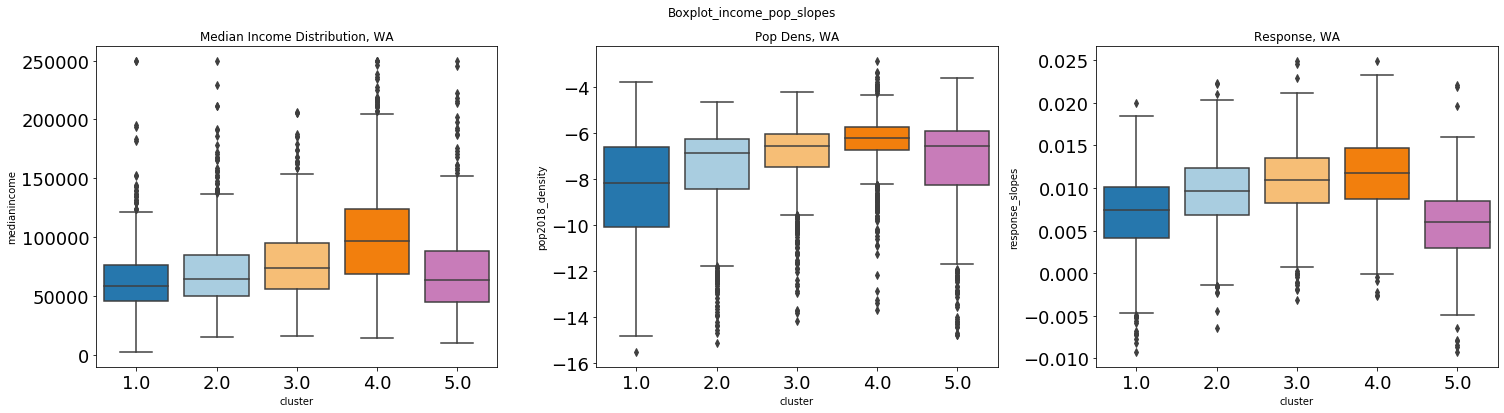

In [132]:
# sns.set_palette('colorblind')
fig, axs = plt.subplots(1,3, figsize = (3*7, 3*2))
list_of_data = [(labels_wa, inc_pop_wa, 'WA')]#, (labels_ga, inc_pop_ga, 'GA'), (labels_tx, inc_pop_tx, 'TX'), (labels_ca, inc_pop_ca, 'CA')]
plot_column(list_of_data, 0, 'medianincome', 'Median Income Distribution', axs, 'box')
plot_column(list_of_data, 1, 'pop2018_density', 'Pop Dens', axs, 'box')
plot_column(list_of_data, 2, 'response_slopes', 'Response', axs, 'box')
fig.suptitle('Boxplot_income_pop_slopes')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# fig.savefig(os.path.join(FIGURE_PATH, 'Boxplot_income_pop_slopes.png'), bbox_inches = 'tight')

In [136]:
FIGURE_PATH

'/home/rlevin/covid-mobility-and-behavior/reports/figures'

/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

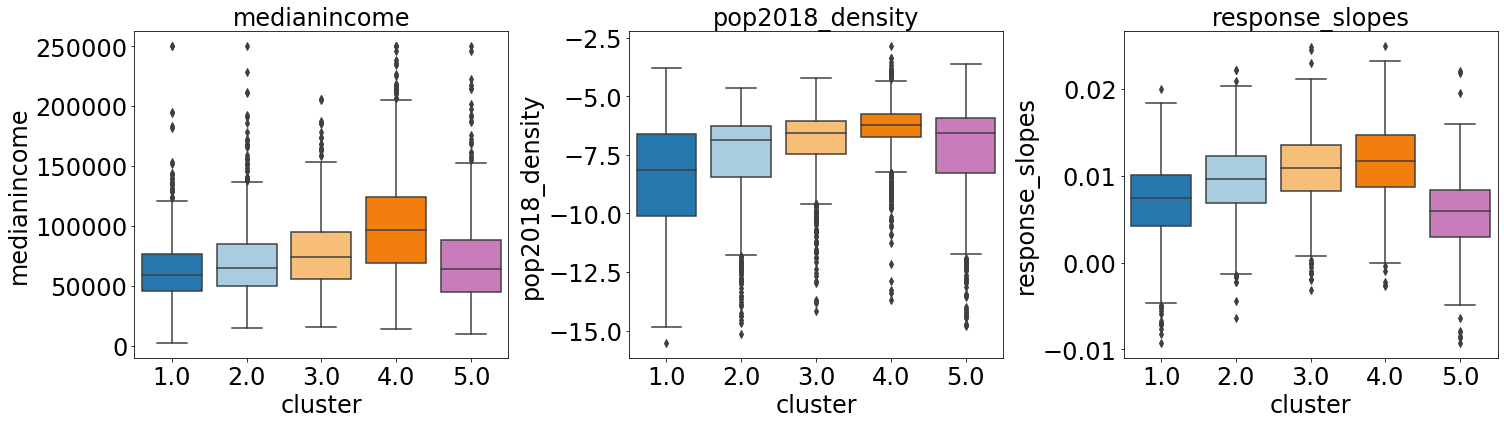

In [139]:
fig, axs = plt.subplots(1,3, figsize = (3*7, 3*2))
plot_state(labels_wa, inc_pop_wa[['medianincome', 'pop2018_density', 'response_slopes']], axs, title_dic = None)
plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, 'Boxplot_income_pop_slopes_WA.png'), bbox_inches = 'tight')

/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/rlevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

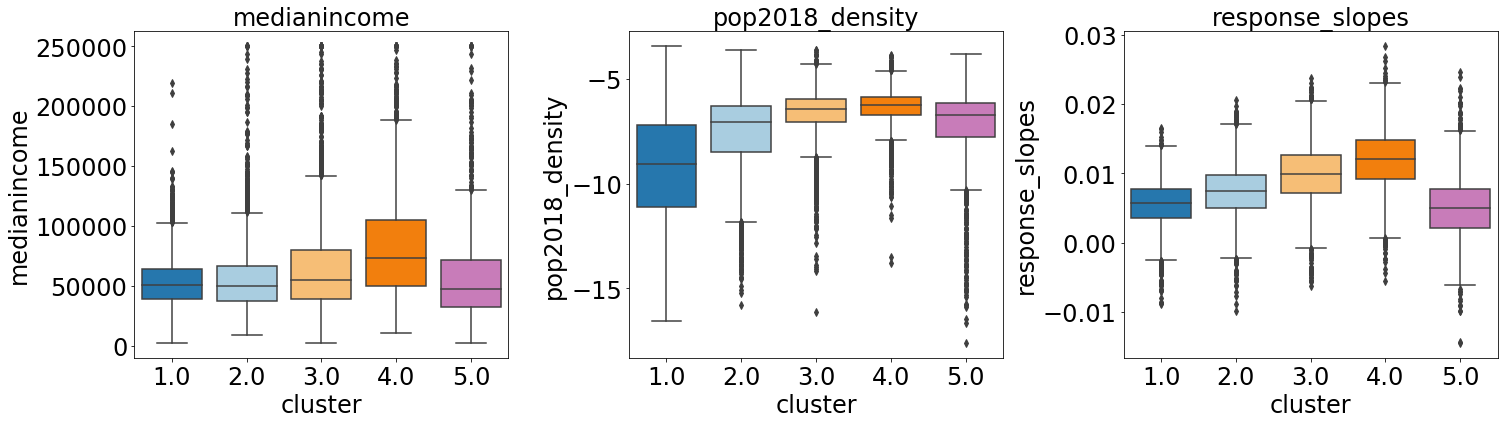

In [140]:
fig, axs = plt.subplots(1,3, figsize = (3*7, 3*2))
plot_state(labels_tx, inc_pop_tx[['medianincome', 'pop2018_density', 'response_slopes']], axs, title_dic = None)
plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, 'Boxplot_income_pop_slopes_TX.png'), bbox_inches = 'tight')

<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


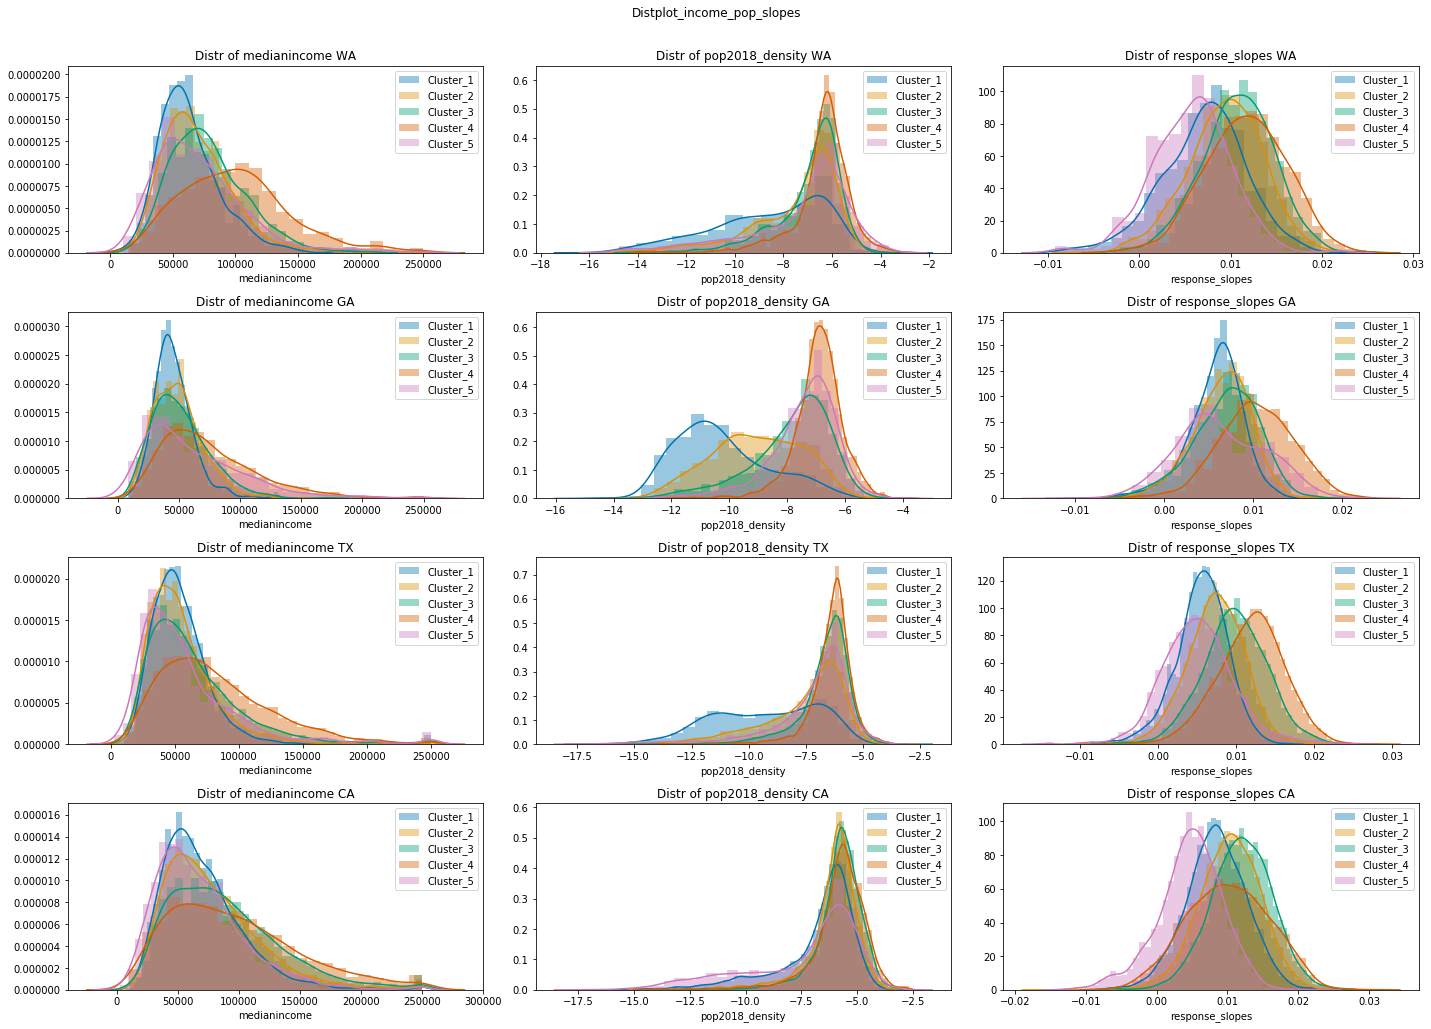

In [83]:
sns.set_palette('colorblind')
fig, axs = plt.subplots(4,3, figsize = (20,15))
list_of_data = [(labels_wa, inc_pop_wa, 'WA'), (labels_ga, inc_pop_ga, 'GA'), (labels_tx, inc_pop_tx, 'TX'), (labels_ca, inc_pop_ca, 'CA')]
plot_column(list_of_data, 0, 'medianincome', axs, 'dist')
plot_column(list_of_data, 1, 'pop2018_density', axs, 'dist')
plot_column(list_of_data, 2, 'response_slopes', axs, 'dist')
fig.suptitle('Distplot_income_pop_slopes')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(os.path.join(FIGURE_PATH, 'Distplot_income_pop_slopes.png'), bbox_inches = 'tight')

In [84]:
from scipy.stats import ks_2samp

def significance_ks(df, by, ax):
    sign_matrix = np.zeros((5,5))
    for i in range(1,6):
        for j in range(1,6):
            x_ = df[by][df.cluster == i]
            y_ = df[by][df.cluster == j]
            ks_stat, pval = ks_2samp(x_, y_)
            D_cr = 1.95*np.sqrt((len(x_)+len(y_))/(len(x_)*len(y_))) #for significance level 0.001, approx
            if ks_stat > D_cr:
#                 print('Null hypothesis rejected with sign 0.001 (that is, we can reject the null hyp about the same distros)')
                sign_matrix[i-1,j-1] = True
            else:
#                 print('We cannot reject the null hypot with sign level 0.001')
                sign_matrix[i-1,j-1] = False
    ax.imshow(sign_matrix)
    return sign_matrix

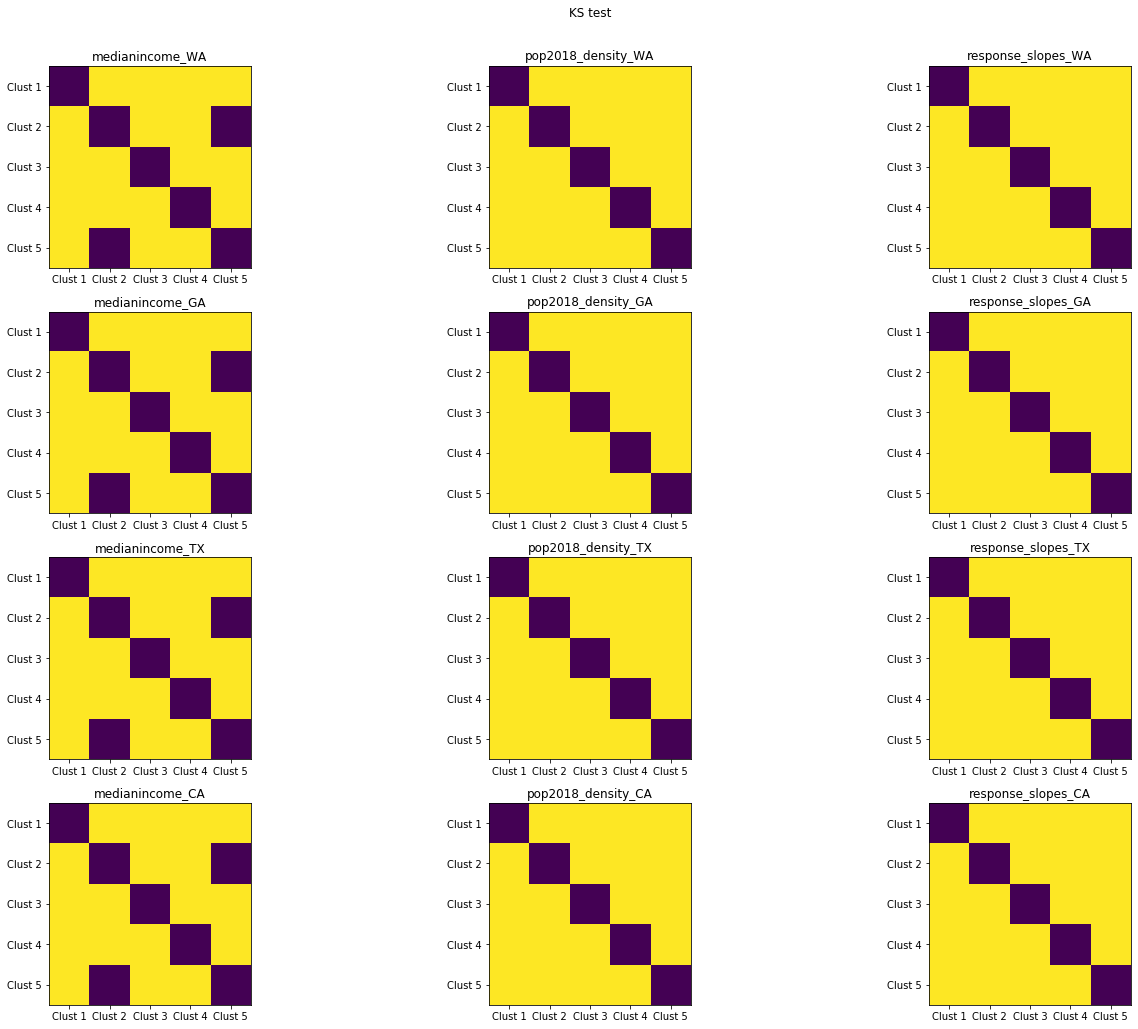

In [85]:
fig, axs = plt.subplots(4, 3, figsize = (20,15))
for col, by in enumerate(['medianincome', 'pop2018_density', 'response_slopes']):
    for row, data in enumerate(list_of_data):
        labels, inc_pop, title = data
        significance_ks(inc_pop_wa, by, ax = axs[row, col])
        axs[row, col].set_title(by + '_' + title)
        axs[row, col].set_yticks(np.arange(0,5))
        axs[row, col].set_xticks(np.arange(0,5))
        axs[row, col].set_yticklabels(['Clust 1', 'Clust 2', 'Clust 3', 'Clust 4', 'Clust 5'])
        axs[row, col].set_xticklabels(['Clust 1', 'Clust 2', 'Clust 3', 'Clust 4', 'Clust 5'])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('KS test')
fig.savefig(os.path.join(FIGURE_PATH, 'KS_test_income_pop_slopes.png'), bbox_inches = 'tight')

In [142]:
#Refs
#http://www.mathwave.com/help/easyfit/html/analyses/goodness_of_fit/kolmogorov-smirnov.html
#https://towardsdatascience.com/statistical-tests-when-to-use-which-704557554740
#https://sparky.rice.edu//astr360/kstest.pdf
#https://towardsdatascience.com/unit-testing-for-data-scientists-dc5e0cd397fb#:~:text=Writing%20tests%20for%20specific%20modules,is%20essentially%20a%20basic%20need.

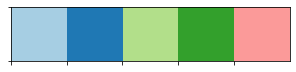

In [5]:
sns.palplot(sns.color_palette("Paired", 5))

In [10]:
colors = [4,3,2,1,5]

In [11]:
friendly_cmap = ListedColormap(sns.color_palette('Paired', len(np.unique(colors))).as_hex())

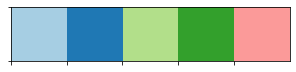

In [12]:
sns.palplot(sns.color_palette('colorblind', len(np.unique(colors))).as_hex())

In [21]:
sns.color_palette('colorblind', len(np.unique(colors))).as_hex()

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc']

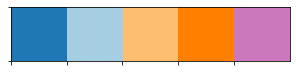

In [23]:
my_pal = ['#1f78b4','#a6cee3','#fdbf6f','#ff7f00', '#cc78bc']
sns.palplot(sns.color_palette(my_pal))